In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [84]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%load_ext autoreload
%autoreload 2

from dataloader import get_single_hits, get_event_hits, get_event_charge
from sklearn.model_selection import train_test_split

from scipy import constants

import gc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
plt.rcParams['figure.figsize'] = [12., 8.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [4]:
tf.test.is_gpu_available()

True

In [5]:
labels = ['x', 'y', 'z', 'time', 'azimuth','zenith', 'energy']

In [204]:
hits_list = []
charges_list = []
params_list = []

q_charges_list = []
q_params_list = []

for i in range(20):
    #fname = '../test_data/oscNext_genie_level3_v01.03_pass2.120000.000%s0.hdf5'%('%s'%i).zfill(2)
    fname = '../test_data/oscNext_genie_level3_v01.03_pass2.140000.000%s00.hdf5'%i
    try:
        hits, charges, params = get_single_hits(
            fname,
            labels = labels,
            )
        hits_list.append(hits)
        charges_list.append(charges)
        params_list.append(params)
        
        
        qc, qp = get_event_charge(
            fname,
            labels = labels,
            )
        q_charges_list.append(qc)
        q_params_list.append(qp)
    except OSError:
        print('Skipping file %s'%fname)
        #raise Exception

hits = np.concatenate(hits_list)
charges = np.concatenate(charges_list)
params = np.concatenate(params_list)

q_charges = np.concatenate(q_charges_list)
q_params = np.concatenate(q_params_list)

  0%|          | 0/406784 [00:00<?, ?it/s]

Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.140000.000000.hdf5


100%|██████████| 13066/13066 [00:19<00:00, 684.24it/s]


Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.140000.0001000.hdf5
Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.140000.0001100.hdf5
Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.140000.0001200.hdf5
Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.140000.0001300.hdf5
Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.140000.0001400.hdf5
Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.140000.0001500.hdf5
Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.140000.0001600.hdf5
Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.140000.0001700.hdf5
Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.140000.0001800.hdf5
Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.140000.0001900.hdf5


In [205]:
hits_train, hits_test, charges_train, charges_test, params_train, params_test = train_test_split(hits, charges, params, test_size=0.1, random_state=42)

q_charges_train, q_charges_test, q_params_train, q_params_test = train_test_split(q_charges, q_params, test_size=0.1, random_state=42)

In [206]:
azimuth_idx = labels.index('azimuth')
zenith_idx = labels.index('zenith')
time_idx = labels.index('time')
x_idx = labels.index('x')
y_idx = labels.index('y')
z_idx = labels.index('z')
energy_idx = labels.index('energy')

speed_of_light = constants.c * 1e-9 # c in m / ns

class trafo(tf.keras.layers.Layer):
    '''Class to transfor inputs for Hit Net
    '''
    def call(self, hit, params):
        
        dir_x = tf.math.sin(params[:, zenith_idx]) * tf.math.cos(params[:, azimuth_idx])
        dir_y = tf.math.sin(params[:, zenith_idx]) * tf.math.sin(params[:, azimuth_idx])
        dir_z = tf.math.cos(params[:, zenith_idx])
        
        d_time = hit[:,3] - params[:, time_idx]
        d_x = hit[:,0] - params[:, x_idx]
        d_y = hit[:,1] - params[:, y_idx]
        d_z = hit[:,2] - params[:, z_idx]
        
        dist = tf.math.sqrt(tf.math.square(d_x) + tf.math.square(d_y) + tf.math.square(d_z))
        
        # difference c*t - r
        delta = d_time * speed_of_light - dist

        energy = params[:, energy_idx]
        
        out = tf.concat([hit[:, 0:3], delta[:, tf.newaxis], dist[:, tf.newaxis], params[:, x_idx:z_idx+1], dir_x[:, tf.newaxis], dir_y[:, tf.newaxis], dir_z[:, tf.newaxis], energy[:, tf.newaxis]], axis=1)
                
        return out
    
class trafo_q(tf.keras.layers.Layer):
    '''Class to transfor inputs for Charget Net
    '''
    def call(self, charge, params):
        
        dir_x = tf.math.sin(params[:, zenith_idx]) * tf.math.cos(params[:, azimuth_idx])
        dir_y = tf.math.sin(params[:, zenith_idx]) * tf.math.sin(params[:, azimuth_idx])
        dir_z = tf.math.cos(params[:, zenith_idx])

        energy = params[:, energy_idx]
        
        out = tf.concat([charge, params[:, x_idx:z_idx+1], dir_x[:, tf.newaxis], dir_y[:, tf.newaxis], dir_z[:, tf.newaxis], energy[:, tf.newaxis]], axis=1)
                
        return out

In [207]:
class LossHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        self.train_losses = []
        self.test_losses = []

    def on_train_batch_end(self, batch, logs={}):
        self.train_losses.append(logs.get('loss'))
        
    def on_test_batch_end(self, batch, logs={}):
        self.test_losses.append(logs.get('loss'))
   

In [208]:
activation='relu'


hits_input = tf.keras.Input(shape=(4,))
params_input = tf.keras.Input(shape=(len(labels),))
t = trafo()

h = t(hits_input, params_input)
h = tf.keras.layers.Dense(32, activation="relu")(h)
h = tf.keras.layers.Dense(64, activation="relu")(h)
h = tf.keras.layers.Dropout(0.001)(h)
h = tf.keras.layers.Dense(128, activation="relu")(h)
h = tf.keras.layers.Dropout(0.001)(h)
h = tf.keras.layers.Dense(256, activation="relu")(h)
h = tf.keras.layers.Dropout(0.001)(h)
h = tf.keras.layers.Dense(128, activation="relu")(h)
h = tf.keras.layers.Dropout(0.001)(h)
h = tf.keras.layers.Dense(64, activation="relu")(h)
h = tf.keras.layers.Dense(32, activation="relu")(h)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)


hit_net = tf.keras.Model(inputs=[hits_input, params_input], outputs=outputs)


hit_net.summary()

my_history = LossHistory()


loss_history = []
val_loss_history = []

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 7)]          0                                            
__________________________________________________________________________________________________
trafo_4 (trafo)                 (None, 12)           0           input_17[0][0]                   
__________________________________________________________________________________________________
dense_40 (Dense)                (None, 32)           416         trafo_4[0][0]                    
____________________________________________________________________________________________

In [209]:
activation='relu'


charge_input = tf.keras.Input(shape=(1,))
params_input = tf.keras.Input(shape=(len(labels),))
t = trafo_q()

h = t(charge_input, params_input)
h = tf.keras.layers.Dense(32, activation="relu")(h)
h = tf.keras.layers.Dense(64, activation="relu")(h)
h = tf.keras.layers.Dropout(0.001)(h)
h = tf.keras.layers.Dense(128, activation="relu")(h)
h = tf.keras.layers.Dropout(0.001)(h)
h = tf.keras.layers.Dense(256, activation="relu")(h)
h = tf.keras.layers.Dropout(0.001)(h)
h = tf.keras.layers.Dense(128, activation="relu")(h)
h = tf.keras.layers.Dropout(0.001)(h)
h = tf.keras.layers.Dense(64, activation="relu")(h)
h = tf.keras.layers.Dense(32, activation="relu")(h)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)


charge_net = tf.keras.Model(inputs=[charge_input, params_input], outputs=outputs)


charge_net.summary()

my_history_q = LossHistory()


loss_history_q = []
val_loss_history_q = []

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 7)]          0                                            
__________________________________________________________________________________________________
trafo_q_4 (trafo_q)             (None, 8)            0           input_19[0][0]                   
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 32)           288         trafo_q_4[0][0]                  
____________________________________________________________________________________________

In [210]:
optimizer = tf.keras.optimizers.Adam(0.0005)

hit_net.compile(loss='binary_crossentropy', optimizer=optimizer)

In [211]:
optimizer = tf.keras.optimizers.Adam(0.0005)

charge_net.compile(loss='binary_crossentropy', optimizer=optimizer)

In [212]:
def shuffle(hits, params, each_row=True):
    shuffled_hits = np.vstack([hits, hits])
    if each_row:
        shuf = np.empty_like(params)
        for col in range(params.shape[1]):
            indices = np.random.permutation(np.arange(params.shape[0]))
            shuf[:, col] = params[indices, col]
    else:
        shuf = np.random.permutation(params)
    shuffled_params = np.vstack([params, shuf])
    target = np.concatenate([np.ones(hits.shape[0]), np.zeros(hits.shape[0])])
    return shuffled_hits, shuffled_params, target

In [ ]:
for i in range(200):
    
    shuffled_hits_train, shuffled_params_train, outputs_train = shuffle(hits_train, params_train)
    shuffled_hits_test, shuffled_params_test, outputs_test = shuffle(hits_test, params_test)
    
    gc.collect()

    print('Epoch %i'%(len(loss_history)+1))
    
    hit_net.fit([shuffled_hits_train, shuffled_params_train], outputs_train, batch_size=2048, epochs=1, validation_data=([shuffled_hits_test, shuffled_params_test], outputs_test), callbacks=[my_history,])

    loss_history.append(hit_net.history.history['loss'])
    val_loss_history.append(hit_net.history.history['val_loss'])
   

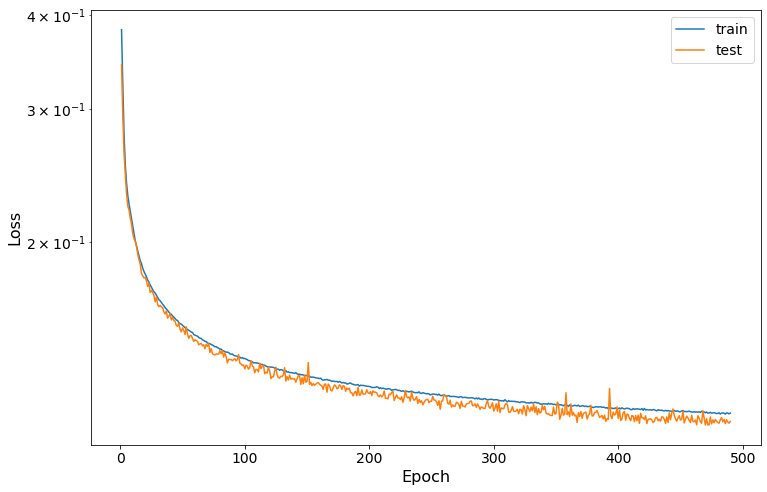

In [311]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
x = np.arange(1, len(loss_history)+1)
ax.plot(x, np.concatenate(loss_history), label='train')
ax.plot(x, np.concatenate(val_loss_history), label='test')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

In [292]:
hit_net.save('hit_net.h5')

Epoch 91
Train on 213540 samples, validate on 23728 samples
213540/213540 [==============================] - 0s 2us/sample - loss: 0.4244 - val_loss: 0.4285
Epoch 91
Train on 213540 samples, validate on 23728 samples
213540/213540 [==============================] - 0s 2us/sample - loss: 0.4225 - val_loss: 0.4375
Epoch 91
Train on 213540 samples, validate on 23728 samples
213540/213540 [==============================] - 0s 2us/sample - loss: 0.4235 - val_loss: 0.4380
Epoch 91
Train on 213540 samples, validate on 23728 samples
213540/213540 [==============================] - 0s 2us/sample - loss: 0.4218 - val_loss: 0.4367
Epoch 91
Train on 213540 samples, validate on 23728 samples
213540/213540 [==============================] - 0s 2us/sample - loss: 0.4208 - val_loss: 0.4371
Epoch 91
Train on 213540 samples, validate on 23728 samples
213540/213540 [==============================] - 0s 1us/sample - loss: 0.4216 - val_loss: 0.4315
Epoch 91
Train on 213540 samples, validate on 23728 sample

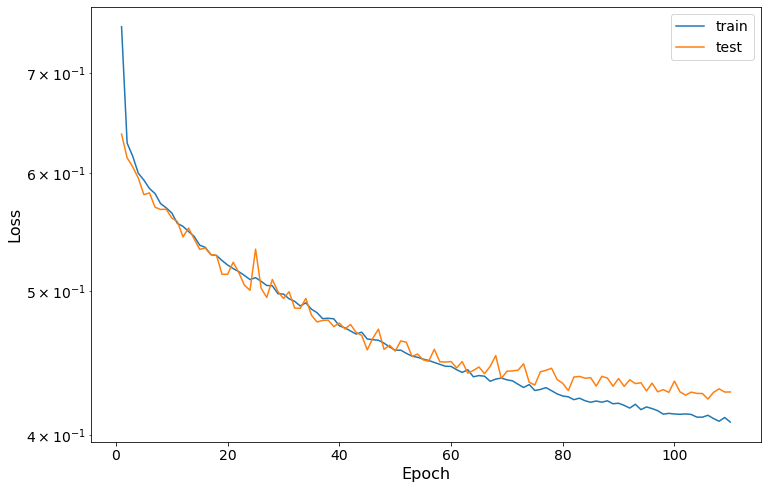

In [231]:
for i in range(30):
    
    shuffled_q_charges_train, shuffled_q_params_train, outputs_q_train = shuffle(q_charges_train, q_params_train)
    shuffled_q_charges_test, shuffled_q_params_test, outputs_q_test = shuffle(q_charges_test, q_params_test)
    
    gc.collect()

    print('Epoch %i'%(len(loss_history)+1))
    
    charge_net.fit([shuffled_q_charges_train.flatten()[:, np.newaxis], shuffled_q_params_train], outputs_q_train, batch_size=2048, epochs=1, validation_data=([shuffled_q_charges_test.flatten()[:, np.newaxis], shuffled_q_params_test], outputs_q_test), callbacks=[my_history_q,])

    loss_history_q.append(charge_net.history.history['loss'])
    val_loss_history_q.append(charge_net.history.history['val_loss'])
    

fig, ax = plt.subplots(1, 1, figsize=(12,8))
x = np.arange(1, len(loss_history_q)+1)
ax.plot(x, np.concatenate(loss_history_q), label='train')
ax.plot(x, np.concatenate(val_loss_history_q), label='test')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

In [331]:
hit_idx = 404

true_params = params_test[hit_idx]
true_hit = hits_test[hit_idx]

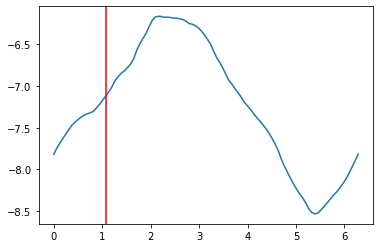

In [333]:
plot_dim = 'azimuth'
plot_idx = labels.index(plot_dim)

true_p = true_params[plot_idx]

if plot_dim == 'zenith':
    xs = np.linspace(0, np.pi, 100)
elif plot_dim == 'azimuth':
    xs = np.linspace(0, 2*np.pi, 100)
else:
    delta = 500
    xs = np.linspace(true_p-delta, true_p+delta, 100)

params = np.repeat(true_params, xs.shape[0]).reshape(-1, xs.shape[0]).T
hits = np.repeat(true_hit, xs.shape[0]).reshape(-1, xs.shape[0]).T

params[:, plot_idx] = xs

likelihood = model.predict([hits, params], batch_size=512)

#likelihood /= 1 - likelihood

llh = np.log(likelihood) - np.log(1 - likelihood)

plt.plot(xs, -llh)
plt.axvline(true_p, c='r')


In [133]:
hf, cf, pf = get_event_hits('../test_data/oscNext_genie_level3_v01.03_pass2.140000.000001.hdf5', labels=labels, N_events=None)
qf, pqf = get_event_charge('../test_data/oscNext_genie_level3_v01.03_pass2.140000.000001.hdf5', labels=labels, N_events=None)


100%|██████████| 13222/13222 [00:24<00:00, 548.71it/s]


In [200]:
epsilon = 1e-10

In [355]:
def get_llh(event_idx, plot_dim, n_steps=100):

    plot_idx = labels.index(plot_dim)
    true_p = pf[event_idx][plot_idx]

    if plot_dim == 'zenith':
        xs = np.linspace(0, np.pi, n_steps)
    elif plot_dim == 'azimuth':
        xs = np.linspace(0, 2*np.pi, n_steps)
    elif plot_dim == 'energy':
        xs = np.linspace(0, 10*true_p, n_steps)
    else:
        delta = 50
        if plot_dim == 'time':
            delta *= 3
        xs = np.linspace(true_p-delta, true_p+delta, n_steps)

    n_hits = hf[event_idx].shape[0]

    params = np.repeat(pf[event_idx][np.newaxis, :], repeats=n_steps, axis=0)#.reshape(-1, 2)
    params[:, plot_idx] = xs
    
    
    q_charges = np.repeat(qf[event_idx], repeats=n_steps)
    q_llh = charge_net.predict([q_charges[:, np.newaxis], params], batch_size=512)
    
    q_llh = q_llh[:, 0]
    
    q_llh = np.clip(q_llh, epsilon, 1-epsilon)
    
    q_llh = np.log(q_llh) - np.log(1 - q_llh)
    

    params = np.repeat(params[np.newaxis, :], repeats=n_hits, axis=0).reshape(n_hits*n_steps, -1)
    hits = np.repeat(hf[event_idx][:, np.newaxis, :], repeats=n_steps, axis=1).reshape(n_hits*n_steps, -1)

    likelihood = hit_net.predict([hits, params], batch_size=512)
    
    likelihood = np.clip(likelihood, epsilon, 1-epsilon)
    
    llh = np.log(likelihood) - np.log(1 - likelihood)
    
    return xs, llh.reshape(-1, n_steps), q_llh

In [356]:
def plot_llh(event_idx, plot_dim, ax, n_steps=100):
    n_hits = hf[event_idx].shape[0]
    
    colors = plt.cm.Wistia(np.linspace(0,1,n_hits))
    plot_idx = labels.index(plot_dim)

    
    xs, llh, qllh = get_llh(event_idx, plot_dim, n_steps=n_steps)
    
    #llh = np.nan_to_num(llh)
    
    for i in range(n_hits):
        l = -cf[event_idx][i]*llh[i]
        l -= np.min(l)
        label = 'Indiv. hit' if i == n_hits -1 else None
        ax.plot(xs, l, c=colors[i], alpha=0.8, label=label)
    ax.axvline(pf[event_idx][plot_idx], c='r', label='truth')

    h = -np.sum(cf[event_idx] * llh.T, axis=1)
    h -= np.min(h)
    ax.plot(xs, h, c='deepskyblue', ls='-', lw=2, label='All hits')
    
    q = -qllh
    q -= np.min(q)
    ax.plot(xs, q, c='green', lw=2, label='Charge')
    
    tot = q + h
    tot -= np.min(tot)
    ax.plot(xs, tot, c='k', lw=2, label='Total')

    ax.axvline(xs[np.argmin(tot)], c='k', ls='--', label='Minimum')
    
    ax.set_xlabel(plot_dim)
    ax.set_ylabel(r'$\Delta$ LLH')
    #plt.legend()

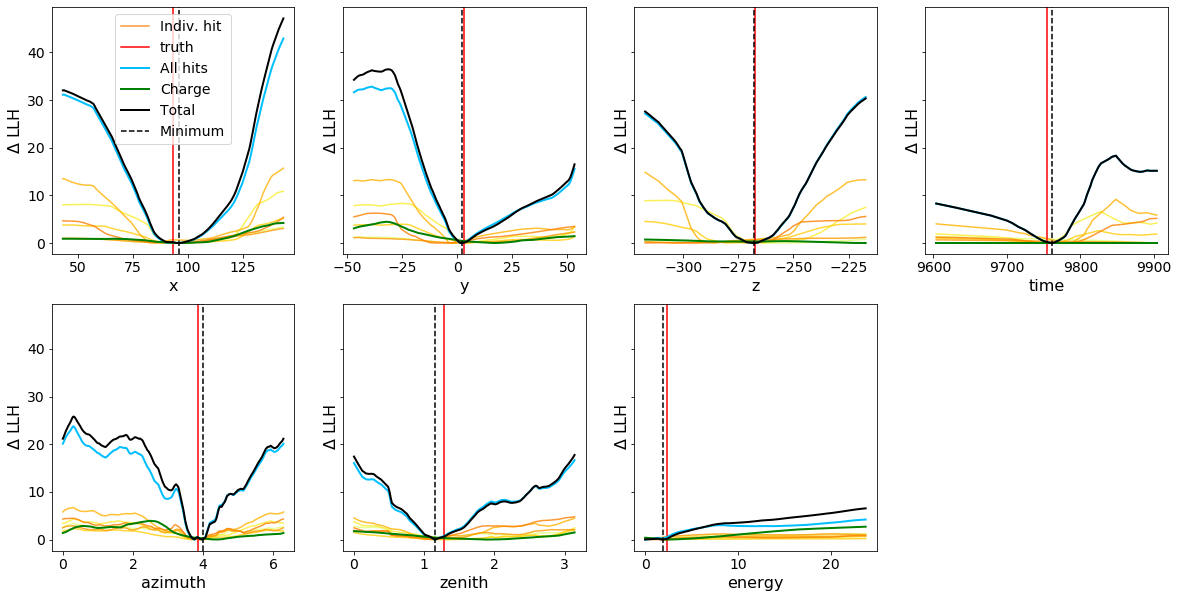

In [365]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10), sharey=True)

for i in range(ax.size):

    axis = ax[i//4, i%4]

    
    if i >= len(labels):
        axis.set_axis_off()
        continue
    
    evt = 137
    
    plot_llh(evt, labels[i], axis, n_steps=1000) #1756, 987
    
    if i == 0:
        axis.legend()
        
plt.savefig('hitnet_event%i.png'%evt)